In [1]:
import sys
sys.path.append('../_amigocloud')

In [2]:
import simplekml

In [55]:
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
#from shapely.geometry import Point, MultiPoint
import os
#from fastkml import kml

In [4]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

In [5]:
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# ACTUALIZAR SHP PLANIFICACION

In [6]:
ors = 25

In [7]:
# leer los dos shps de siembra y puntos de planificacion
path_siembras = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\SIEMBRAS.shp'
path_cat = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\catastro140624.shp'
path_puntos = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PUNTOS_PLAN.shp'

gdf_siembras = gpd.read_file(path_siembras)
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [8]:
# verifica si ambos shps tienen el mismo CRS
if gdf_siembras.crs == gdf_puntos.crs:
    print('Ambas capas tienen el mismo CRS')
else:
    print('No tienen el mismo CRS')

Ambas capas tienen el mismo CRS


In [10]:
# filtrar la semna de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,dia,obs,geometry
7,388,AGROPECUARIA MARIANA S.R.L.,25,0,NaN,"MULTIPOINT (483761.985 8092400.324, 484394.001..."


In [11]:
multipoint_gdf = gdf_puntos_sem

In [12]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [13]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,dia,obs,geometry
7,388,AGROPECUARIA MARIANA S.R.L.,25,0,NaN,POINT (483761.985 8092400.324)
7,388,AGROPECUARIA MARIANA S.R.L.,25,0,NaN,POINT (484394.001 8092117.639)
7,388,AGROPECUARIA MARIANA S.R.L.,25,0,NaN,POINT (485194.058 8091947.787)
7,388,AGROPECUARIA MARIANA S.R.L.,25,0,NaN,POINT (485409.566 8091393.926)
7,388,AGROPECUARIA MARIANA S.R.L.,25,0,NaN,POINT (485718.110 8092014.480)
7,388,AGROPECUARIA MARIANA S.R.L.,25,0,NaN,POINT (485916.238 8092525.574)


<Axes: >

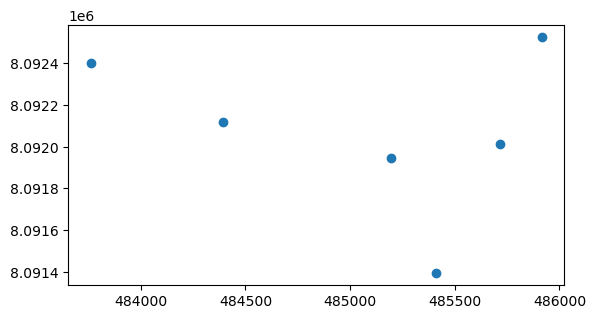

In [14]:
puntos_indi.plot()

In [15]:
# Asegurarse de que ambos GeoDataFrames tienen el mismo sistema de coordenadas (CRS)
if puntos_indi.crs != gdf_siembras.crs:
    print('Los CRS no son iguales')
    #gdf_siembras = gdf_siembras.to_crs(puntos_indi.crs)
else:
    print('Los CRS si son iguales')

Los CRS si son iguales


In [16]:
# Crear un GeoDataFrame vacío para almacenar los puntos que no intersectan con ningún polígono
puntos_indi_solicitado = puntos_indi[~puntos_indi.geometry.apply(lambda point: any(gdf_siembras.contains(point)))]

In [17]:
puntos_indi_solicitado

,unidad_03,unidad_04,os,dia,obs,geometry


In [18]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi_solicitado, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [19]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [20]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry


In [21]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi_solicitado.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [22]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry


In [24]:
poligonos_intersect_cat['fecha_ini'] = ''
poligonos_intersect_cat['origen'] = 'SOLICITUD'
poligonos_intersect_cat['dias'] = 0
poligonos_intersect_cat['fecha'] = ''
poligonos_intersect_cat['os'] = ors

In [25]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os


In [27]:
# SELECCIONAR LOS LOTES DE SIEMBRAS
# identifoca los lotes que se intersectan
gdf_lotes_siem = gpd.sjoin(gdf_siembras, multipoint_gdf, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_siem = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_siem.index)]
# copy
poligonos_intersect_siem = poligonos_intersect_siem.copy()
# agregar campo de semana_planificacion
poligonos_intersect_siem['os'] = ors

In [28]:
poligonos_intersect_siem['soca'] = poligonos_intersect_siem['origen'].apply(lambda x: 1 if 'SIEMBRA 2023' in x else 0)

In [29]:
poligonos_intersect_siem = poligonos_intersect_siem[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area',
       'fecha_ini', 'origen', 'dias', 'fecha', 'prioridad', 'inst', 'geometry', 'os', 'soca']]

In [30]:
poligonos_intersect_siem

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,prioridad,inst,geometry,os,soca
530,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L4,16.738872,2024-05-15,SIEMBRA 2024,43.0,2024-05-15,2,69.0,"POLYGON ((485384.867 8091584.716, 485378.243 8...",25,0
539,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L16,5.915662,2024-04-22,SIEMBRA 2024,66.0,2024-04-22,2,69.0,"POLYGON ((484215.046 8092239.909, 483231.027 8...",25,0
541,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L12.1,5.150160,2024-04-26,SIEMBRA 2024,62.0,2024-04-26,2,69.0,"POLYGON ((485402.284 8091927.747, 485346.732 8...",25,0
545,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L9,32.409977,2024-04-12,SIEMBRA 2024,76.0,2024-04-12,2,69.0,"POLYGON ((485576.705 8092277.515, 485871.818 8...",25,0
546,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L6,13.544786,2024-04-25,SIEMBRA 2024,63.0,2024-04-25,2,69.0,"POLYGON ((485966.005 8092033.968, 485857.002 8...",25,0
548,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L15,16.591264,2024-04-21,SIEMBRA 2024,67.0,2024-04-21,2,69.0,"POLYGON ((484408.814 8091852.010, 484393.835 8...",25,0


In [31]:
# Concatenar los DataFrames a lo largo de las filas (axis=0)
plan = pd.concat([poligonos_intersect_cat, poligonos_intersect_siem], axis=0)
# Si deseas restablecer el índice después de concatenar
plan.reset_index(drop=True, inplace=True)

C:\Users\bismarksr\AppData\Local\Temp\ipykernel_24928\1203562612.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plan = pd.concat([poligonos_intersect_cat, poligonos_intersect_siem], axis=0)


<Axes: >

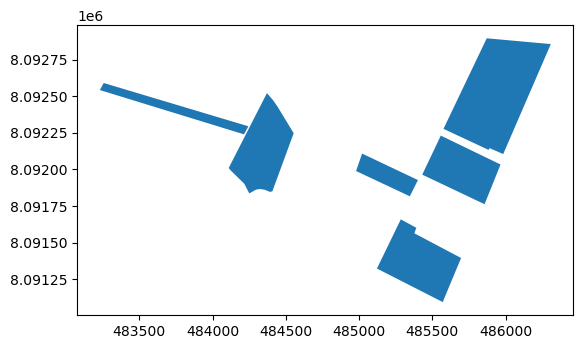

In [32]:
plan.plot()

In [33]:
plan['area'].sum()

90.35071985275

In [34]:
plan['area'] = plan.geometry.area / 10000

In [35]:
plan['area'].sum()

90.35071985266597

In [36]:
# cargar el shp de planificacion existente
path_plan = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION_TEST.shp'
gdf_plan = gpd.read_file(path_plan)

In [37]:
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [38]:
last_id

0

In [39]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [40]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os,prioridad,id
0,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L4,16.738872,0,69.0,"POLYGON ((485384.867 8091584.716, 485378.243 8...",2024-05-15,SIEMBRA 2024,43.0,2024-05-15,25,2.0,1
1,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L16,5.915662,0,69.0,"POLYGON ((484215.046 8092239.909, 483231.027 8...",2024-04-22,SIEMBRA 2024,66.0,2024-04-22,25,2.0,2
2,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L12.1,5.150160,0,69.0,"POLYGON ((485402.284 8091927.747, 485346.732 8...",2024-04-26,SIEMBRA 2024,62.0,2024-04-26,25,2.0,3
3,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L9,32.409977,0,69.0,"POLYGON ((485576.705 8092277.515, 485871.818 8...",2024-04-12,SIEMBRA 2024,76.0,2024-04-12,25,2.0,4
4,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L6,13.544786,0,69.0,"POLYGON ((485966.005 8092033.968, 485857.002 8...",2024-04-25,SIEMBRA 2024,63.0,2024-04-25,25,2.0,5
5,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L15,16.591264,0,69.0,"POLYGON ((484408.814 8091852.010, 484393.835 8...",2024-04-21,SIEMBRA 2024,67.0,2024-04-21,25,2.0,6


In [41]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

C:\Users\bismarksr\AppData\Local\Temp\ipykernel_24928\364328693.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)


In [42]:
gdf_pla_gral['area'].sum()

90.35071985266597

In [43]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
#gdf_pla_gral['prioridad'] = gdf_pla_gral['prioridad'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [44]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [45]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [46]:
# repreyectar a WGS84
gdf_pla_gral = gdf_pla_gral.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [47]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,prioridad,os,soca,id,inst,geometry
0,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L4,16.738872,2024-05-15,SIEMBRA 2024,43,2024-05-15,2.0,25,0,1,69,"MULTIPOLYGON (((-63.13750 -17.26083, -63.13756..."
1,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L16,5.915662,2024-04-22,SIEMBRA 2024,66,2024-04-22,2.0,25,0,2,69,"MULTIPOLYGON (((-63.14850 -17.25490, -63.15775..."
2,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L12.1,5.150160,2024-04-26,SIEMBRA 2024,62,2024-04-26,2.0,25,0,3,69,"MULTIPOLYGON (((-63.13733 -17.25773, -63.13785..."
3,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L9,32.409977,2024-04-12,SIEMBRA 2024,76,2024-04-12,2.0,25,0,4,69,"MULTIPOLYGON (((-63.13569 -17.25457, -63.13291..."
4,218,DON QUIJOTE,18358,ROJAS AMELUNGE CARLOS,L6,13.544786,2024-04-25,SIEMBRA 2024,63,2024-04-25,2.0,25,0,5,69,"MULTIPOLYGON (((-63.13203 -17.25678, -63.13305..."
5,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L15,16.591264,2024-04-21,SIEMBRA 2024,67,2024-04-21,2.0,25,0,6,69,"MULTIPOLYGON (((-63.14668 -17.25841, -63.14682..."


In [194]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/33457/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_345601 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, origen, dias, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['origen']}', '{row['dias']}', '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CREAR KMLS DE PLANIFICACION

In [48]:
path_kml = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN'

In [49]:
path_plan = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION_TEST.shp'
gdf_plan = gpd.read_file(path_plan)

In [51]:
gdf_plan_sem = gdf_plan[gdf_plan['os'] == ors]
gdf_plan_sem['area'].sum()

90.35071985266597

In [52]:
lista_cods = list(set(gdf_plan_sem['unidad_01']))

In [53]:
lista_cods

[218, 19]

In [56]:
for i in lista_cods:
    prop = gdf_plan_sem[gdf_plan_sem['unidad_01'] == i]
    prop_wgs = prop.to_crs(epsg=4326)
    output_folder = path_kml + '\\' + str(i)
    print(output_folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Recorrer el GeoDataFrame
    for idx, row in prop_wgs.iterrows():
        # Crear un nuevo documento KML
        kml_doc = simplekml.Kml()
        # Obtener el polígono y el nombre
        polygon = row['geometry']
        name = row['unidad_05']
        # Convertir el polígono en una lista de coordenadas
        coords = [(x, y) for x, y in zip(*polygon.exterior.xy)]    
        # Añadir el polígono al documento KML
        pol = kml_doc.newpolygon(name=name, outerboundaryis=coords)
        # Guardar el archivo KML
        file_name = f"{name}.kml"
        output_path = os.path.join(output_folder, file_name)
        kml_doc.save(output_path)

C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN\218
C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN\19


# CARGAR XLSX